# Analysis of Nasdaq Closing Cross auction dataset in Julia

#### Each trading day on the Nasdaq Stock Exchange concludes with the Nasdaq Closing Cross auction. This process establishes the official closing prices for securities listed on the exchange. There are a lot of factors in this roughly 10 minutes auction that affect the closing price. Bid price which determines the highest amount someone is willing to pay for the stock has a significant impact on the closing price of the stock
#### In this project the aim is to analyse the historic data for the daily ten minute closing auction on the NASDAQ stock exchange. And finding the parameters having maximum impact on bid_price using Julia. The data for this project was taken from the following [kaggle competition](https://www.kaggle.com/competitions/optiver-trading-at-the-close/data). 

A little description about the data:-

1. stock_id - A unique identifier for the stock. 
2. date_id - A unique identifier for the date. 
3. imbalance_size - The amount unmatched at the current reference price (in USD).
4. imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
a. buy-side imbalance; 1
b. sell-side imbalance; -1
c. no imbalance; 0
5. reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
6. matched_size - The amount that can be matched at the current reference price (in USD).
7. far_price - The crossing price that will maximize the number of shares matched based on auction interest only. 
8. near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
9. [bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.
10. [bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.
11. wap - The weighted average price in the non-auction book.
12. seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
13. target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.


In [1]:
##to install any of the packeages imported below please uncomment the following code and change Package_name

# using Pkg
# Pkg.add("Package_name")

### Importing packages

In [2]:
#import the follwoing packages 

using CSV
using DataFrames
using Statistics
using Plots
using PyCall
using DataStructures
using StatsBase
using CategoricalArrays
using StatsPlots
using Random
using GLM

### Fetching the Dataframe

In [3]:
df = CSV.read("train.csv", DataFrame)
first(df, 5)

Row,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
,Int64,Int64,Int64,Float64?,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64?,Float64,Float64?,Float64,Int64,String15
1,0,0,0,3.1806e6,1,0.999812,1.33803e7,missing,missing,0.999812,60651.5,1.00003,8493.03,1.0,-3.0297,0,0_0_0
2,1,0,0,1.66604e5,-1,0.999896,1.64221e6,missing,missing,0.999896,3233.04,1.00066,20605.1,1.0,-5.51999,0,0_0_1
3,2,0,0,3.0288e5,-1,0.999561,1.81937e6,missing,missing,0.999403,37956.0,1.0003,18995.0,1.0,-8.38995,0,0_0_2
4,3,0,0,1.19177e7,-1,1.00017,1.83897e7,missing,missing,0.999999,2324.9,1.00021,4.79032e5,1.0,-4.0102,0,0_0_3
5,4,0,0,447550.0,-1,0.999532,1.78606e7,missing,missing,0.999394,16485.5,1.00002,434.1,1.0,-7.34985,0,0_0_4


In [4]:
size(df) #getting the size of the data frame

(5237980, 17)

### Descriptive Statistics

In [5]:
describe(df) #getting a full description of the data frame

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,stock_id,99.2886,0,99.0,199,0,Int64
2,date_id,241.51,0,242.0,480,0,Int64
3,seconds_in_bucket,270.0,0,270.0,540,0,Int64
4,imbalance_size,5.71529e6,0.0,1.1136e6,2.98203e9,220,"Union{Missing, Float64}"
5,imbalance_buy_sell_flag,-0.0118962,-1,0.0,1,0,Int64
6,reference_price,0.999996,0.935285,0.999967,1.07749,220,"Union{Missing, Float64}"
7,matched_size,4.51002e7,4316.61,1.28826e7,7.71368e9,220,"Union{Missing, Float64}"
8,far_price,1.00171,7.7e-5,0.999883,437.953,2894342,"Union{Missing, Float64}"
9,near_price,0.99966,0.786988,0.999889,1.30973,2857180,"Union{Missing, Float64}"


In [6]:
names(df) #names of all the features (columns)

17-element Vector{String}:
 "stock_id"
 "date_id"
 "seconds_in_bucket"
 "imbalance_size"
 "imbalance_buy_sell_flag"
 "reference_price"
 "matched_size"
 "far_price"
 "near_price"
 "bid_price"
 "bid_size"
 "ask_price"
 "ask_size"
 "wap"
 "target"
 "time_id"
 "row_id"

In [7]:
# Extract numerical columns

numerical_data = select(df, Not([eltype(df[!, col]) <: AbstractString for col in names(df)]))
first(numerical_data, 5)

Row,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
,Int64,Int64,Int64,Float64?,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64?,Float64,Float64?,Float64,Int64
1,0,0,0,3.1806e6,1,0.999812,1.33803e7,missing,missing,0.999812,60651.5,1.00003,8493.03,1.0,-3.0297,0
2,1,0,0,1.66604e5,-1,0.999896,1.64221e6,missing,missing,0.999896,3233.04,1.00066,20605.1,1.0,-5.51999,0
3,2,0,0,3.0288e5,-1,0.999561,1.81937e6,missing,missing,0.999403,37956.0,1.0003,18995.0,1.0,-8.38995,0
4,3,0,0,1.19177e7,-1,1.00017,1.83897e7,missing,missing,0.999999,2324.9,1.00021,4.79032e5,1.0,-4.0102,0
5,4,0,0,447550.0,-1,0.999532,1.78606e7,missing,missing,0.999394,16485.5,1.00002,434.1,1.0,-7.34985,0


### Statistical Analysis of the data using heatmap

Performing statistical analysis to drive insights from the data.

In [8]:
# Replace missing values with 0.0
numerical_data .= coalesce.(numerical_data, 0.0)
first(numerical_data, 5)

Row,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
,Int64,Int64,Int64,Float64?,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64?,Float64,Float64?,Float64,Int64
1,0,0,0,3.1806e6,1,0.999812,1.33803e7,0.0,0.0,0.999812,60651.5,1.00003,8493.03,1.0,-3.0297,0
2,1,0,0,1.66604e5,-1,0.999896,1.64221e6,0.0,0.0,0.999896,3233.04,1.00066,20605.1,1.0,-5.51999,0
3,2,0,0,3.0288e5,-1,0.999561,1.81937e6,0.0,0.0,0.999403,37956.0,1.0003,18995.0,1.0,-8.38995,0
4,3,0,0,1.19177e7,-1,1.00017,1.83897e7,0.0,0.0,0.999999,2324.9,1.00021,4.79032e5,1.0,-4.0102,0
5,4,0,0,447550.0,-1,0.999532,1.78606e7,0.0,0.0,0.999394,16485.5,1.00002,434.1,1.0,-7.34985,0


In [9]:
# Identify integer columns
int_columns = names(numerical_data, Int)


# Convert integer columns to float
numerical_data[!, int_columns] .= float.(numerical_data[!, int_columns])
first(numerical_data, 5)

Row,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64
1,0.0,0.0,0.0,3.1806e6,1.0,0.999812,1.33803e7,0.0,0.0,0.999812,60651.5,1.00003,8493.03,1.0,-3.0297,0.0
2,1.0,0.0,0.0,1.66604e5,-1.0,0.999896,1.64221e6,0.0,0.0,0.999896,3233.04,1.00066,20605.1,1.0,-5.51999,0.0
3,2.0,0.0,0.0,3.0288e5,-1.0,0.999561,1.81937e6,0.0,0.0,0.999403,37956.0,1.0003,18995.0,1.0,-8.38995,0.0
4,3.0,0.0,0.0,1.19177e7,-1.0,1.00017,1.83897e7,0.0,0.0,0.999999,2324.9,1.00021,4.79032e5,1.0,-4.0102,0.0
5,4.0,0.0,0.0,447550.0,-1.0,0.999532,1.78606e7,0.0,0.0,0.999394,16485.5,1.00002,434.1,1.0,-7.34985,0.0


In [10]:
names(numerical_data)

16-element Vector{String}:
 "stock_id"
 "date_id"
 "seconds_in_bucket"
 "imbalance_size"
 "imbalance_buy_sell_flag"
 "reference_price"
 "matched_size"
 "far_price"
 "near_price"
 "bid_price"
 "bid_size"
 "ask_price"
 "ask_size"
 "wap"
 "target"
 "time_id"

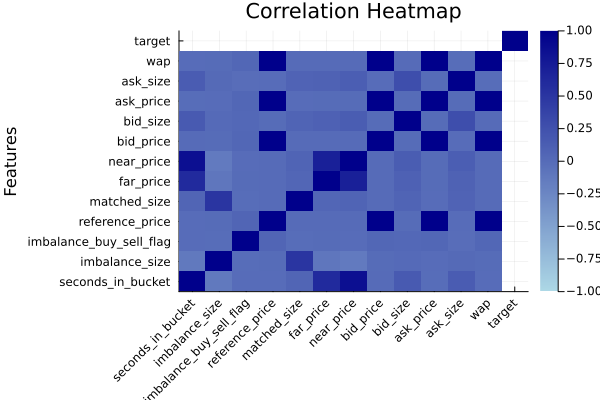

In [11]:
# Select relevant columns
selected_columns = ["seconds_in_bucket", "imbalance_size", "imbalance_buy_sell_flag", "reference_price",
                    "matched_size", "far_price", "near_price", "bid_price", "bid_size", "ask_price",
                    "ask_size", "wap", "target"]

# Create a correlation matrix
correlation_matrix = cor(Matrix(numerical_data[:, selected_columns]))

# Plot heatmap


#### blue color is used to show variation in correlation kindly change the vale assigned to c in the code below-
#### if there is any difficulty in understandin the variation

heatmap(selected_columns, selected_columns, correlation_matrix,
        title="Correlation Heatmap",
        xlabel="Features",
        ylabel="Features",
        xrotation=45,
        c=:blues,
        clim=(-1, 1))


#### Taking a subsample of the data

As it can be seen the data set we have at hand here is huge, with more than 5 million rows. Due to limitation of computational power we will try working on a sub-sample of the data-set, we will reduce the size and try to work on it, to not deviate by a significant margin from the properties of current data set we will compare the heatmap and descriptive statistics of the subsampled and original datasets.

In [18]:
original_rows = size(numerical_data, 1)  # Get the original number of rows
desired_sample_size = 10000  # Desired sample size

# Randomly select rows
random_indices = rand(1:original_rows, desired_sample_size)
sampled_df = numerical_data[random_indices, :]
first(sampled_df, 5)

Row,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64
1,196.0,388.0,40.0,0.0,0.0,1.00043,2.46945e6,0.0,0.0,1.00015,11888.9,1.00043,394.02,1.00042,2.52008,21344.0
2,81.0,392.0,10.0,4.95694e6,-1.0,0.999727,5.63701e6,0.0,0.0,0.998672,8851.7,1.00084,4032.25,1.00016,1.44958,21561.0
3,180.0,461.0,150.0,2.04817e6,1.0,0.998051,2.03165e6,0.0,0.0,0.997744,34083.9,0.998051,7331.44,0.997997,10.2699,25370.0
4,160.0,263.0,200.0,1.93657e7,-1.0,0.99834,7.23593e7,0.0,0.0,0.99823,4323.12,0.99834,37651.3,0.998241,-6.16014,14485.0
5,91.0,100.0,280.0,3.70198e6,-1.0,1.00133,1.54326e7,0.0,0.0,1.00126,12304.5,1.00152,1420.11,1.00149,-1.72973,5528.0


### Descriptive statistics of subsampled data 

In [13]:
describe(sampled_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,Type
1,stock_id,99.1608,0.0,98.0,199.0,0,Float64
2,date_id,241.66,0.0,242.0,480.0,0,Float64
3,seconds_in_bucket,270.31,0.0,270.0,540.0,0,Float64
4,imbalance_size,5.82078e6,0.0,1.08599e6,7.58501e8,0,"Union{Missing, Float64}"
5,imbalance_buy_sell_flag,-0.0109,-1.0,0.0,1.0,0,Float64
6,reference_price,0.999891,0.0,0.99995,1.05354,0,"Union{Missing, Float64}"
7,matched_size,4.57211e7,0.0,1.29903e7,6.41694e9,0,"Union{Missing, Float64}"
8,far_price,0.455472,0.0,0.0,1.27784,0,"Union{Missing, Float64}"
9,near_price,0.463129,0.0,0.0,1.10229,0,"Union{Missing, Float64}"


### Heatmap of the subsampled data

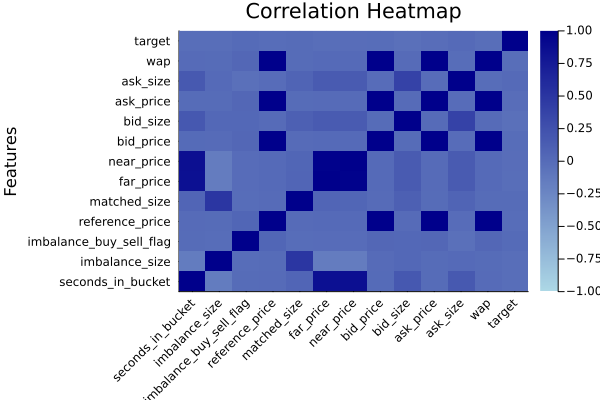

In [14]:
# Select relevant columns
selected_columns = ["seconds_in_bucket", "imbalance_size", "imbalance_buy_sell_flag", "reference_price",
                    "matched_size", "far_price", "near_price", "bid_price", "bid_size", "ask_price",
                    "ask_size", "wap", "target"]

# Create a correlation matrix
correlation_matrix = cor(Matrix(sampled_df[:, selected_columns]))

# Plot heatmap 

#### blue color is used to show variation in correlation kindly change the vale assigned to c in the code below-
#### if there is any difficulty in understandin the variation 

heatmap(selected_columns, selected_columns, correlation_matrix, 
        title="Correlation Heatmap",
        xlabel="Features",
        ylabel="Features",
        xrotation=45,
        c=:blues,
        clim=(-1, 1))


As it can be seen from the two heat maps that features having a correlation of more than 50% are consistent in the two data-sets, also from the descriptive statistics of the two data-sets it is clear that they do not deviate by much so can move ahead with the subsampled dataframe.

### Performing regression analysis

This is done to get an uderstanding of 2 things:-

1. P-value which helps in gauging the imporatnce of the associated predictors of the target variable (bid_price) in our case.

2. R-squared value which determines the proportion of variance in the dependent variable that can be explained by the independent variable

First lets start with taking all the feature vectors for predicting the target at once.

In [15]:
# Define the model
model = lm(@formula(bid_price ~ stock_id + date_id + seconds_in_bucket + imbalance_size +
                     imbalance_buy_sell_flag + reference_price + matched_size + far_price +
                     near_price + bid_size + ask_price + ask_size + wap + time_id),
           sampled_df)

# Summarize the regression results
println("Regression Summary:")
println(coef(model)) 
println("The last value represents the p-value.\n")

#Drawing more Statistical insight
println("Statistical information:\n")

println("R-squared value")
println("\nR-squared:", r2(model))
    
print("\nAdjusted-R-squared value\n")
println("\nAdjusted R-squared: ", adjr2(model))
    

Regression Summary:
[0.0, 0.00291101542948181, 0.0, 0.0010895434920524024, 2.6963254915229403e-9, 0.0, 0.0, -1.0324330063338554e-10, 0.0, 0.0, 1.1884598139185719e-7, 0.0, 4.348093928208455e-8, 0.0, 2.2435104058071236e-5]
The last value represents the p-value.

Statistical information:

R-squared value

R-squared:-924.6856936917196

Adjusted-R-squared value

Adjusted R-squared: -925.2414941682682


The p-value is less than 0.05 which supports our hypothesis of using all the features at once for predicting bid_price. But if we notice the R-squared-value is -944.5227623062601 which indicates there is something wrong with either the model or the data as the R-squared value lie between 0 and 1.

Let's try using those features which as per the heatmaps have a correlation of more than or equal to 75% with the bid_price.

These will be:- reference_price, ask_price, wap, 

In [16]:
# Define the model
model = lm(@formula(bid_price ~ reference_price + ask_price + wap), sampled_df)

# Summarize the regression results
println("Regression Summary:")
println(coef(model)) 
println("The last value represents the p-value.\n")

#Drawing more Statistical insight
println("Statistical information:\n")

println("R-squared value")
println("\nR-squared:", r2(model))
    
print("\nAdjusted-R-squared value\n")
println("\nAdjusted R-squared: ", adjr2(model))

Regression Summary:
[0.0008508902149638224, 0.4426379842144153, -0.3866462938540647, 0.9429915860395669]
The last value represents the p-value.

Statistical information:

R-squared value

R-squared:0.998982995645371

Adjusted-R-squared value

Adjusted R-squared: 0.9989826904219752


This time we have a R-squared value of 99.9% which indicates that any movement in bid_price can be explained by the features taken into consideration to very significant extent. However we have a p value which is > 0.05 which hints that these features are not a statistically significant predictor of bid_price.

Let's try taking more features into account this time all those that have a correlation of more than 50%. These will be - reference_price, ask_price, wap, imbalance_buy_sell_flag, far_pice, near_price.

In [17]:
# Define the model
model = lm(@formula(bid_price ~ reference_price + ask_price + wap + imbalance_buy_sell_flag + far_price + near_price), sampled_df)

# Summarize the regression results
println("Regression Summary:")
println(coef(model)) 
println("The last value represents the p-value.\n")

#Drawing more Statistical insight
println("Statistical information:\n")

println("R-squared value")
println("\nR-squared:", r2(model))
    
print("\nAdjusted-R-squared value\n")
println("\nAdjusted R-squared: ", adjr2(model))

Regression Summary:
[0.000559516151971252, 0.5079613644294192, -0.4009385750278202, 0.8922361837269409, -8.317216193638194e-5, 8.70984208810989e-5, -4.571247915893844e-5]
The last value represents the p-value.

Statistical information:

R-squared value

R-squared:0.999032322244667

Adjusted-R-squared value

Adjusted R-squared: 0.9990317412313044


This gives us a p-value less than 0.05 and R-squared value of 99.9% suggesting the following:-

_Coefficient Significance_: The P-value is suggesting that the corresponding features (independent variables) are likely a statistically significant predictor of the target (dependent variable).

_R-squared Value_: An R-squared value of 99.9% indicates that the model explains a very high percentage of the variability in the dependent variable. This is a strong indicator that the model fits the data extremely well.

_Overall Model Fit_: The combination of a low p-value and a high R-squared value suggests that the model is statistically significant and provides an excellent fit to the data.

### Conclusion 

From this limited statistical analysis we were able to conclude that reference_price, ask_price, wap, imbalance_buy_sell_flag, far_pice, near_price can be used to explain variation in bid_price.

### Scope of improvement

_Overfitting_: Extremely high R-squared values may sometimes indicate overfitting, where the model fits the training data too closely and may not generalize well to new, unseen data.

_Domain Knowledge_: While statistical significance is crucial, the ultimate interpretation should also consider the theoretical or practical significance of the findings within the specific domain or field of study.

_Assumptions_: Regression models have assumptions, and violations of these assumptions could affect the validity of the results. It's important to check for assumptions such as linearity, independence of residuals, and normality.

### Future work 

I would like to do a thorough statistical analysis of this dataset deploying other methods. FSurther I want to develop robust prediction models to be able to predict bid_price and eventually closing price using real time data during the last 10 minutes of closing auction of a trading day.